In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
# Import forecast data 
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [12]:
# Import forecast data at surface
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
exp_sfc = {}
for experiment in experiments:
    exp_sfc[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [4]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'))
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-23 00'))


# Calculate advection

In [74]:
def calc_advection_q(ds, level=850):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    dqdlon =ds.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.sel(level=level).latitude, ds.sel(level=level).longitude.values[:-2], ds.sel(level=level).latitude, ds.sel(level=level).longitude[2:])
    dqdlat = ds.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.sel(level=level).latitude.values[:-2], ds.sel(level=level).longitude, ds.sel(level=level).latitude[2:], ds.sel(level=level).longitude)
    
    # Calculate advection
    adv = (ds.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (ds.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [80]:
# Calculate scalar advection
level = 850
adv = {}
for experiment in experiments:
    adv[experiment] = calc_advection_q(exp[experiment], level=level) 

# Calculate unit vector of wind
u = {}
v = {}
for experiment in experiments:
    u[experiment] = (exp[experiment].u / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))
    v[experiment] = (exp[experiment].v / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))

In [81]:
# Advection in ERA5
adv_era5 = calc_advection_q(era5, level=level)

# Calculate unit vector of wind in ERA5
u_era5 = (era5.u / np.sqrt(era5.u**2 + era5.v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))
v_era5 = (era5.v / np.sqrt(era5.u**2 + era5.v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))

In [82]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 48, 70]
northsea = [-17, 20, 40, 70]

# Plot current mean and time series

Text(0.5, 1.0, 'Advection and mean wind direction, 10-19 00 to 10-22 00, 850 hPa')

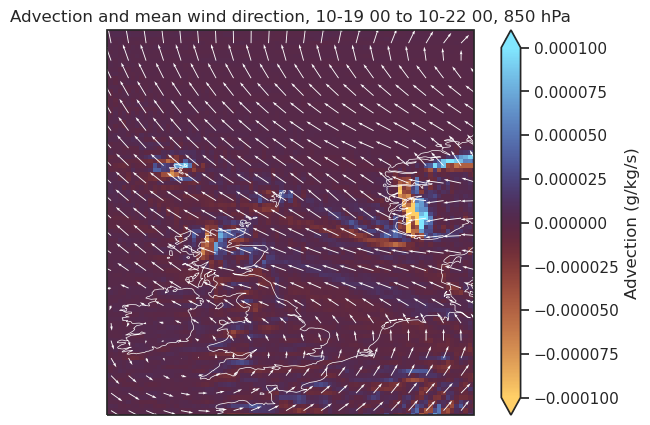

In [84]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(uk, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

# Plot scalar advection
(adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])).plot(vmin=-1e-4, vmax=1e-4, 
                                                                                               cmap=cm.managua, 
                                                                                               ax=ax, 
                                                                                               transform=ccrs.PlateCarree(),
                                                                                               cbar_kwargs={"label": "Advection (g/kg/s)"})

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
          u['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
          v['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
          transform=ccrs.PlateCarree(), scale=20, color='white')
plt.title(f'Advection and mean wind direction, 10-19 00 to 10-22 00, {level} hPa')

Text(0.5, 0.98, 'Advection and wind direction, 850 hPa')

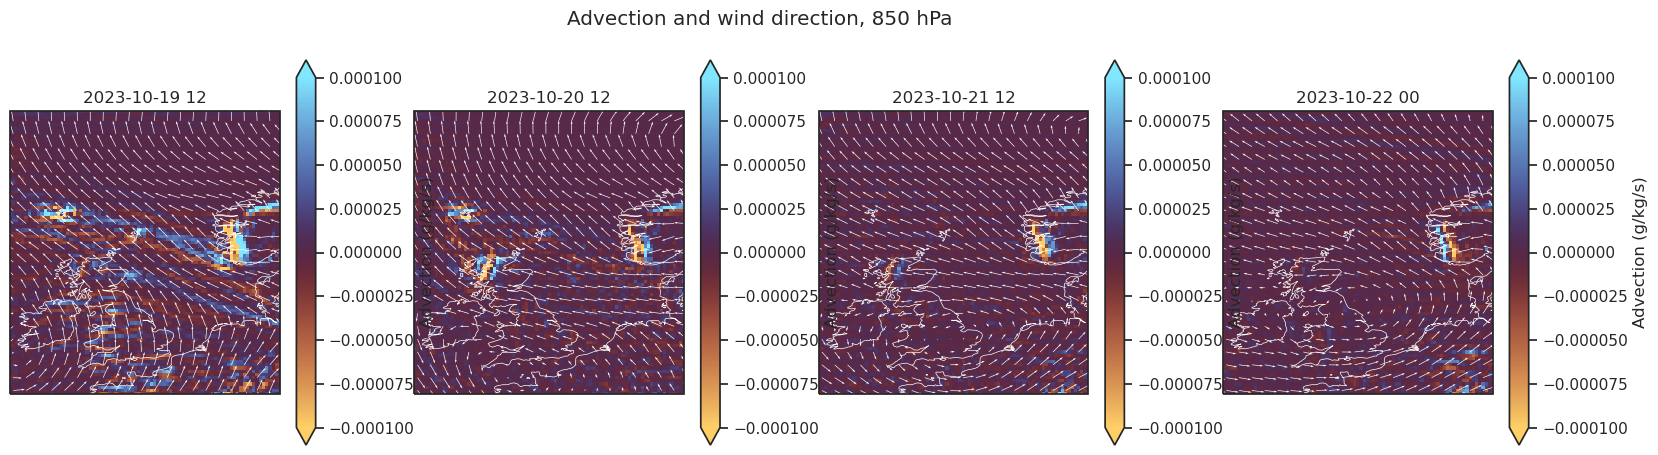

In [85]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

    # Plot scalar advection
    (adv['curr'].sel(time=time, inidate=inidate).mean('number')).plot(vmin=-1e-4, vmax=1e-4, 
                                                                    cmap=cm.managua, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "Advection (g/kg/s)"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='white')
    ax[i].set_title(f'{time}')
plt.suptitle(f'Advection and wind direction, {level} hPa')

# Surface advection in curr

In [56]:
def calc_surf_advection_q(ds, ds_sfc):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    level = 1000
    dqdlon = ds.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.sel(level=level).latitude, ds.sel(level=level).longitude.values[:-2], ds.sel(level=level).latitude, ds.sel(level=level).longitude[2:])
    dqdlat = ds.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.sel(level=level).latitude.values[:-2], ds.sel(level=level).longitude, ds.sel(level=level).latitude[2:], ds.sel(level=level).longitude)
    
    # Calculate advection
    adv = np.absolute((ds_sfc.u10.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon)) + np.absolute((ds_sfc.v10.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat))
    return adv

In [58]:
# Calculate scalar surface advection
adv_sfc = {}
for experiment in experiments:
    adv_sfc[experiment] = calc_surf_advection_q(exp[experiment], exp_sfc[experiment]) 

# Calculate unit vector of wind
u_sfc = {}
v_sfc = {}
for experiment in experiments:
    u_sfc[experiment] = (exp_sfc[experiment].u10 / np.sqrt(exp_sfc[experiment].u10**2 + exp_sfc[experiment].v10**2)).isel(latitude=slice(1, -1), longitude=slice(1, -1))
    v_sfc[experiment] = (exp_sfc[experiment].v10 / np.sqrt(exp_sfc[experiment].u10**2 + exp_sfc[experiment].v10**2)).isel(latitude=slice(1, -1), longitude=slice(1, -1))

Text(0.5, 0.98, 'Advection and wind direction, 1000 hPa')

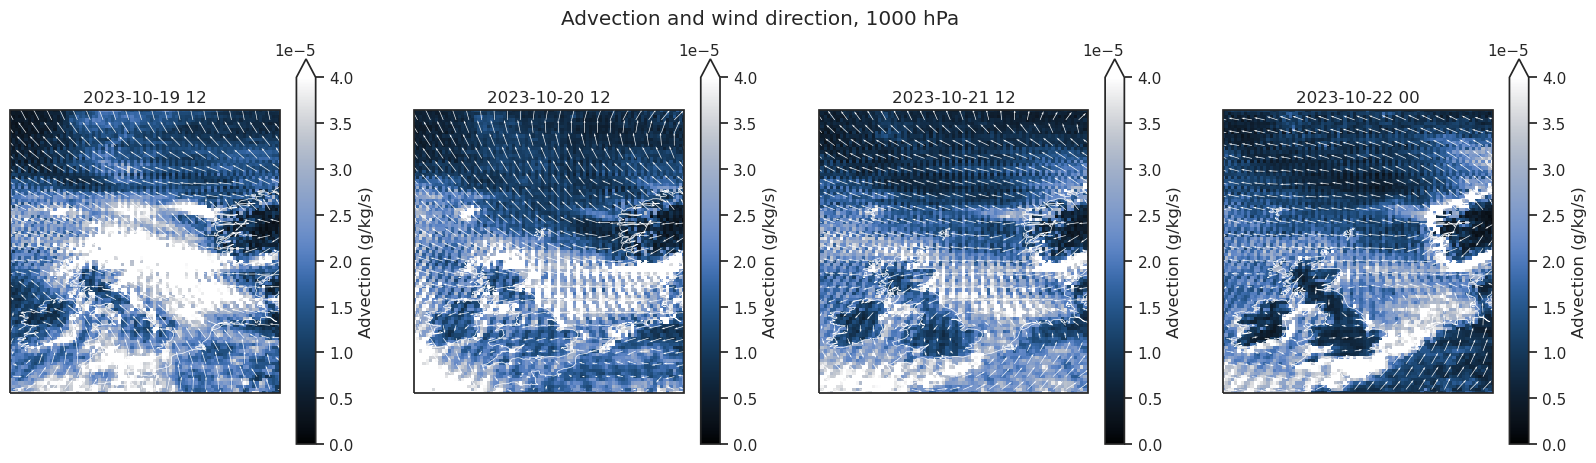

In [62]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 1000

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

    # Plot scalar advection
    (adv_sfc['curr'].sel(time=time, inidate=inidate).mean('number')).plot(vmin=0, vmax=4e-5, 
                                                                    cmap=cm.oslo, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "Advection (g/kg/s)"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u_sfc['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v_sfc['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='white')
    ax[i].set_title(f'{time}')
plt.suptitle(f'Advection and wind direction, {level} hPa')

# Specific humidity timeseries

Text(0.5, 0.98, 'q and wind direction, 850 hPa')

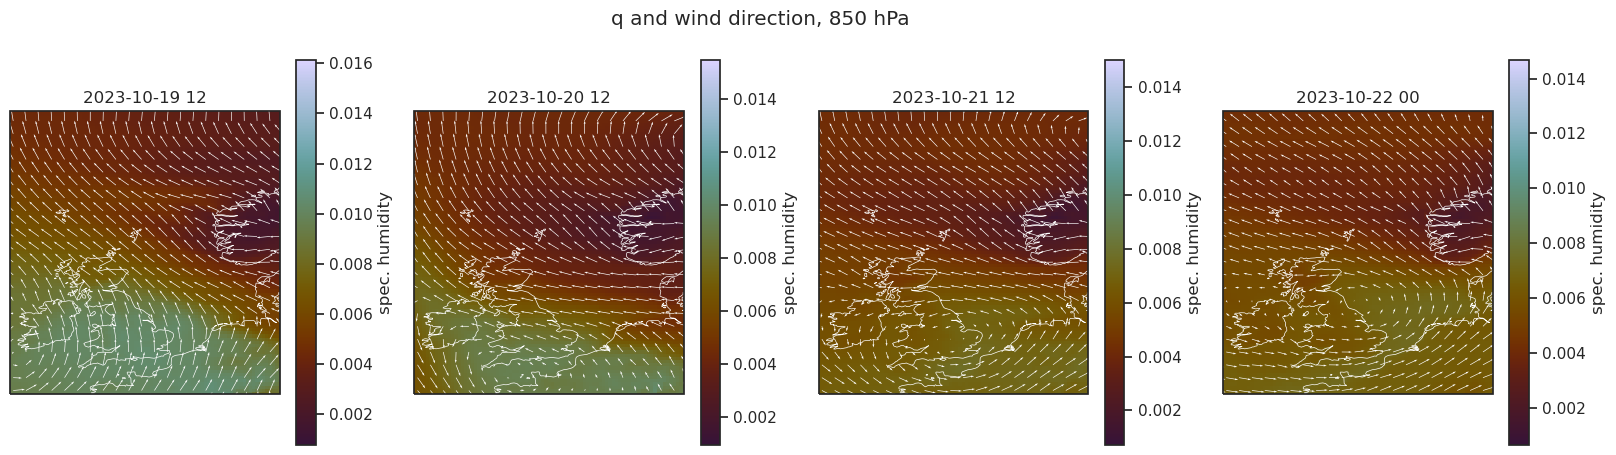

In [29]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

    # Plot scalar advection
    (exp['curr'].q.sel(time=time, inidate=inidate, level=1000).mean('number')).plot(cmap=cm.glasgow, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "spec. humidity"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='white')
    ax[i].set_title(f'{time}')
plt.suptitle(f'q and wind direction, {level} hPa')

Text(0.5, 0.98, 'q and wind direction, 1000 hPa')

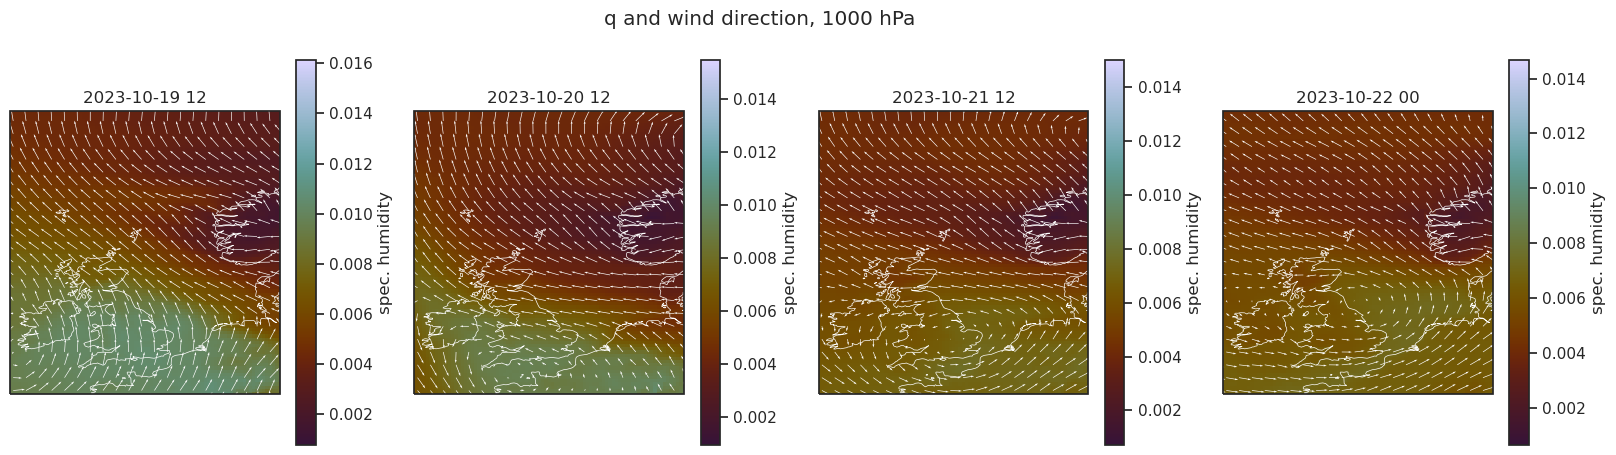

In [30]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 1000

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

times = ['2023-10-19 12', '2023-10-20 12', '2023-10-21 12', '2023-10-22 00']

fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for i, time in enumerate(times):
    ax[i].set_extent(uk, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

    # Plot scalar advection
    (exp['curr'].q.sel(time=time, inidate=inidate, level=1000).mean('number')).plot(cmap=cm.glasgow, 
                                                                    ax=ax[i],
                                                                    transform=ccrs.PlateCarree(),
                                                                    cbar_kwargs={"label": "spec. humidity"})

    # Plot wind vectors
    stride = 4
    llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
    ax[i].quiver(llon, llat, 
            u['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            v['curr'].sel(time=time, inidate=inidate).mean('number')[::stride, ::stride], 
            transform=ccrs.PlateCarree(), scale=20, color='white')
    ax[i].set_title(f'{time}')
plt.suptitle(f'q and wind direction, {level} hPa')

# Compare experiments

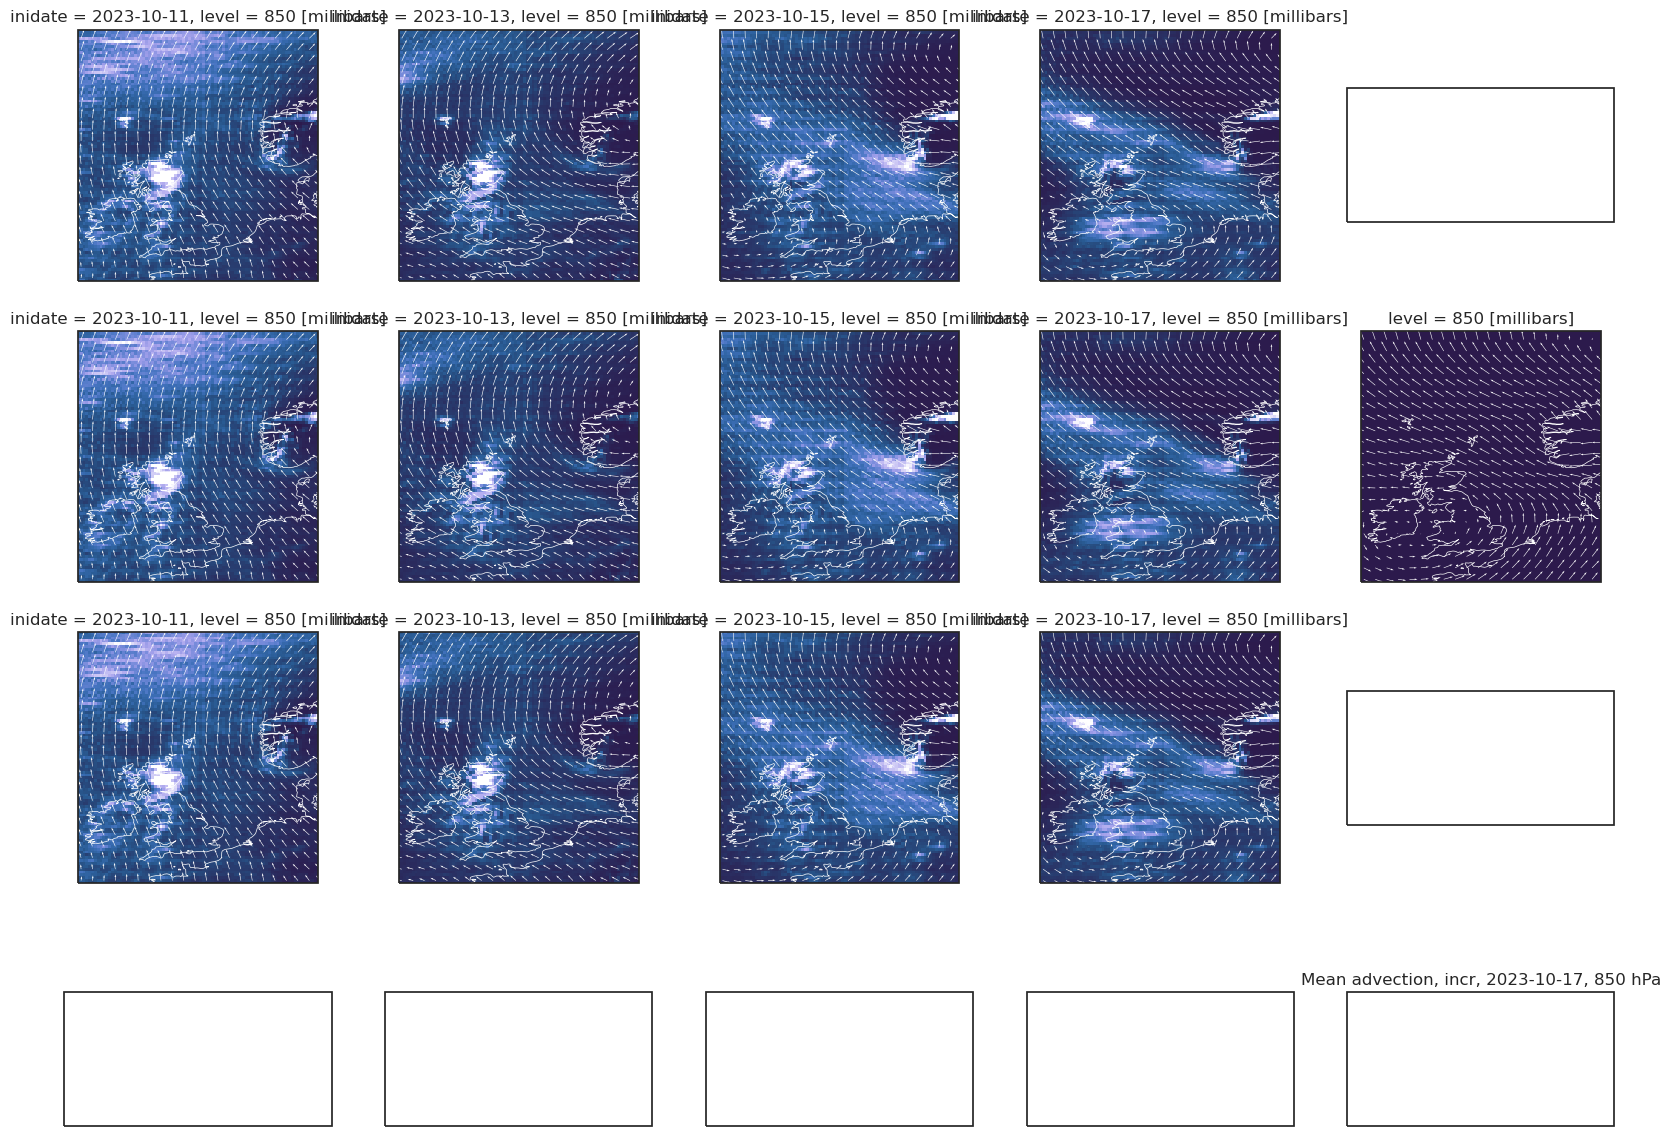

In [8]:
inidate = '2023-10-17'
time = '2023-10-20 09'
level = 850

latitude = exp['curr'].latitude.values[1:-1]
longitude = exp['curr'].longitude.values[1:-1]

starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig, ax = plt.subplots(3, 5, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot experiment fields ------------------------------
for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        ax[e][i].set_extent(uk, crs=ccrs.PlateCarree())
        ax[e][i].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)

        # Plot scalar advection
        (adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])*1e6).plot(vmin=0, vmax=5e-2, 
                                                                                                    cmap=cm.devon, 
                                                                                                    ax=ax[e][i], 
                                                                                                    transform=ccrs.PlateCarree(),
                                                                                                    add_colorbar=False)

        # Plot wind vectors
        stride = 4
        llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
        ax[e][i].quiver(llon, llat, 
                u['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
                v['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
                transform=ccrs.PlateCarree(), scale=20, color='white')
        plt.title(f'Mean advection, {experiment}, {inidate}, {level} hPa')

# Plot ERA5 fields ------------------------------
ax[1][4].set_extent(uk, crs=ccrs.PlateCarree())
ax[1][4].add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=0.5)
adv_era5.sel(time=slice(starttime, endtime)).mean('time').plot(vmin=0, vmax=5e-2,
                                                                cmap=cm.devon, 
                                                                ax=ax[1][4], 
                                                                transform=ccrs.PlateCarree(),
                                                                add_colorbar=False)
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax[1][4].quiver(llon, llat, 
        u_era5.sel(time=slice(starttime, endtime)).mean('time')[::stride, ::stride], 
        v_era5.sel(time=slice(starttime, endtime)).mean('time')[::stride, ::stride], 
        transform=ccrs.PlateCarree(), scale=20, color='white')

In [9]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()

adv_min = 0
adv_max = 0.05

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            adv_vals = ((adv[experiment].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])*1e6) - (adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])*1e6)).squeeze().values
        else: 
            adv_vals = (adv['curr'].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])*1e6).values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'white', zorder = 14)
        # ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # advection as shading
        if experiment =='curr':
            clevs_adv = np.linspace(adv_min, adv_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.devon,
                            transform=projection, zorder = 10, extend = 'both')
        else: 
            clevs_adv = np.linspace(-0.01, 0.01, 10)
            cf_diff = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # Plot wind vectors
        stride = 4
        llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
        ax.quiver(llon, llat, 
                u[experiment].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
                v[experiment].sel(time=slice(starttime, endtime), inidate=inidate).mean(['number', 'time'])[::stride, ::stride], 
                transform=ccrs.PlateCarree(), scale=20, color='white')

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

adv_vals = (adv_era5.sel(time=slice(starttime, endtime)).mean('time')*1e6).values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'white', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# advection as shading
clevs_adv = np.linspace(adv_min, adv_max, 11)  # 17
cf = ax.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.devon,
                transform=projection, zorder = 10, extend = 'both')

# Plot wind vectors
stride = 4
llon, llat = np.meshgrid(longitude[::stride], latitude[::stride])
ax.quiver(llon, llat, 
        u_era5.sel(time=slice(starttime, endtime)).mean('time')[::stride, ::stride], 
        v_era5.sel(time=slice(starttime, endtime)).mean('time')[::stride, ::stride], 
        transform=ccrs.PlateCarree(), scale=20, color='white')

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='advection (g/kg/s)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle(f'Advection at {level}', size = fs)
plt.tight_layout()

plt.savefig('figures/09_advection.png', dpi=600)
plt.savefig('figures/09_advection.pdf')   